In [1]:
from network import Net
from trainers import *
from validator import *
import numpy as np
import pandas as pd

In [8]:
#load data TRAIN
data = pd.read_csv('..\datasets\cup\ML-CUP24-TR.csv', header=None, skiprows=7)
data = data.to_numpy()

#split data in train 80% and test 20%
np.random.shuffle(data)
train = data[:int(len(data)*0.8)]
test = data[int(len(data)*0.8):]

#split in x and y
x_train = train[:,1:-3]
y_train = train[:,-3:]
x_test = test[:,1:-3]
y_test = test[:,-3:]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(200, 12)
(200, 3)
(50, 12)
(50, 3)


In [3]:
network = Net('./config_cup.yaml')
network.print_structure()

Layer 1: Units = 768, Activation = relu
Layer 2: Units = 768, Activation = relu
Layer 3: Units = 3, Activation = identity


In [5]:
# first grid search
valid = Validator('param_grid_cup.yaml')
print(len(valid.grid))

best_configuration = valid.grid_search(x_train, y_train, network)
best_configuration

648


100%|██████████| 648/648 [1:40:58<00:00,  9.35s/it]


{'conf': {'activations': ['relu', 'relu', 'identity'],
  'alpha': 0.9,
  'eta': 0.001,
  'initializer': 'he',
  'lambd': 1e-05,
  'units': [1024, 1024, 3]},
 'epochs': 402,
 'metrics': np.float64(4.077944746740005)}

In [4]:
#second grid search, fine grained
valid = Validator('param_grid_cup2.yaml')
print(len(valid.grid))

best_configuration = valid.grid_search(x_train, y_train, network)
best_configuration

81


100%|██████████| 81/81 [12:21<00:00,  9.15s/it]


{'conf': {'activations': ['relu', 'relu', 'identity'],
  'alpha': 0.8,
  'eta': 0.001,
  'initializer': 'he',
  'lambd': 5e-06,
  'units': [768, 768, 3]},
 'epochs': 303,
 'metrics': np.float64(3.828270287911239)}

Layer 1: Units = 768, Activation = relu
Layer 2: Units = 768, Activation = relu
Layer 3: Units = 3, Activation = identity


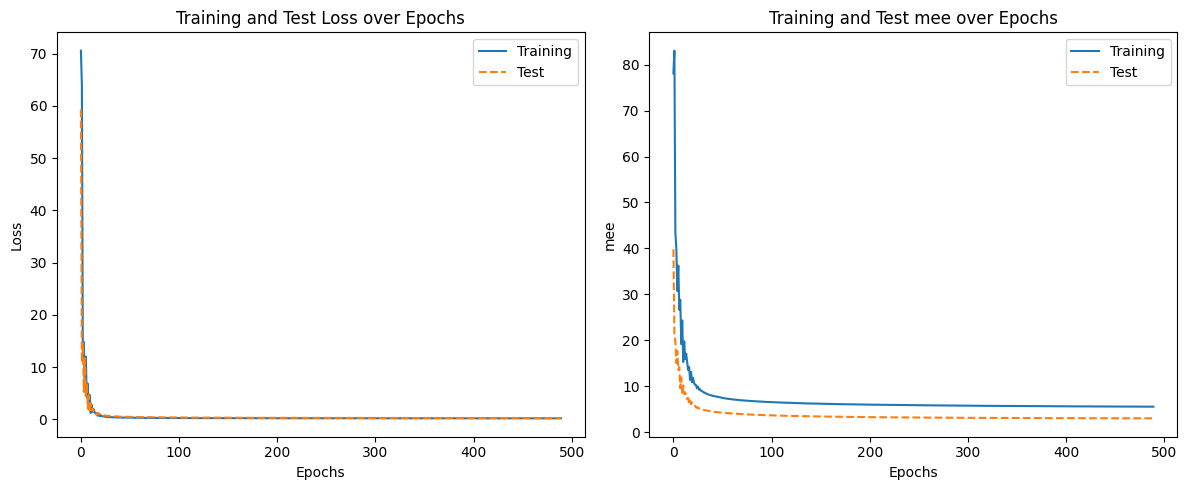

train_loss  :  0.2171962776477626
test_loss  :  0.27981422858867677
train_metric  :  5.519535863004592
test_metric  :  2.980475585551518


In [3]:
#network.set_best_configuration(best_configuration)
network = Net('./config_cup.yaml')
network.print_structure()

results = train_and_evaluate(x_train, y_train, x_test, y_test, network.get_W(), network.get_b(), network.get_layers(), network.get_hyperparameters())

for key in results.keys():
    if key != 'model':
        print(key, ' : ', results[key])

In [4]:
# Retrain the model using all the data
data = pd.read_csv('..\datasets\cup\ML-CUP24-TR.csv', header=None, skiprows=7)
data = data.to_numpy()
np.random.shuffle(data)

#split in x and y
x_train = data[:,1:-3]
y_train = data[:,-3:]

print(x_train.shape)
print(y_train.shape)

(250, 12)
(250, 3)


In [5]:
network = Net('./config_cup.yaml')
network.print_structure()

final_model = train_model(x_train, y_train, network.get_W(), network.get_b(), network.get_layers(), network.get_hyperparameters())

Layer 1: Units = 768, Activation = relu
Layer 2: Units = 768, Activation = relu
Layer 3: Units = 3, Activation = identity


In [6]:
#load data TEST
data_TS = pd.read_csv('..\datasets\cup\ML-CUP24-TS.csv', header=None, skiprows=7)
data_TS = data_TS.to_numpy()
x_TS = data_TS[:,1:]
print(x_TS.shape)

cup_labels = blind_test(x_TS, final_model[0], final_model[1], network.get_layers())
#save cup_labels in a csv file
np.savetxt("cup_labels.csv", cup_labels, delimiter=",")
# print the first 10 labels
print(cup_labels[:10])

(500, 12)
[[  0.15746407  -2.35678687  26.90223888]
 [ -0.50146366   1.57959348  25.58453274]
 [  1.0160454   -0.83247997 -17.0380614 ]
 [  0.19134496  -0.07632404  -3.87825627]
 [  0.08575558   0.07004542   3.14489069]
 [ -1.32601215  -1.39104749  31.54314758]
 [  0.21941861  -0.49121831   5.35067899]
 [ -0.39312429  -0.38457135  -6.24964209]
 [ -1.65884887  -0.1683158   15.80946337]
 [ -0.66371503   0.53170432   8.78846376]]


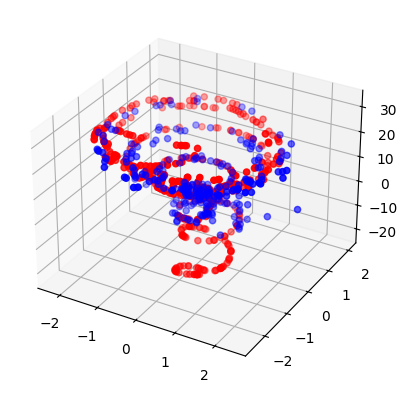

In [7]:
# plot the dataset and the cup_labels in 3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cup_labels[:,0], cup_labels[:,1], cup_labels[:,2], c='r', marker='o')
ax.scatter(y_train[:,0], y_train[:,1], y_train[:,2], c='b', marker='o')
plt.show()